In [1]:
%load_ext autoreload
%autoreload 2
import os

import matplotlib.pyplot as plt
import torch
import torchsde
from torchdyn.core import NeuralODE
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
from tqdm import tqdm
from timm import scheduler

from torchcfm.conditional_flow_matching import *
from torchcfm.models.unet.unet import UNetModelWrapper

savedir = "weights/"
os.makedirs(savedir, exist_ok=True)

In [2]:
import numpy as np
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 256
n_epochs = 20

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)

Files already downloaded and verified


In [4]:
#################################
#            OT-CFM
#################################

sigma = 0.0
#model = UNetModel(dim=(1, 28, 28), num_channels=32, num_res_blocks=1).to(device)
model = UNetModelWrapper(
    dim=(3, 32, 32),
    num_res_blocks=2,
    num_channels=64,
    channel_mult=[1, 2, 2, 2],
    num_heads=4,
    num_head_channels=64,
    attention_resolutions="16",
    dropout=0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
opt_scheduler = scheduler.PolyLRScheduler(warmup_t=45000, warmup_lr_init=1e-8, t_initial=196*n_epochs, optimizer=optimizer)
# FM = ConditionalFlowMatcher(sigma=sigma)
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)
node = NeuralODE(model, solver="euler", sensitivity="adjoint", atol=1e-4, rtol=1e-4)


In [5]:
for epoch in range(n_epochs):
    for i, data in tqdm(enumerate(trainloader)):
        optimizer.zero_grad()
        x1 = data[0].to(device)
        x0 = torch.randn_like(x1)
        t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
        vt = model(t, xt)
        loss = torch.mean((vt - ut) ** 2)
        loss.backward()
        optimizer.step()
        opt_scheduler.step(epoch*(int(50000/batch_size) + 1) + i)
        
    if epoch%3==0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'weights/reproduced_cifar10_weights_epoch_{}.pt'.format(epoch))

196it [01:18,  2.49it/s]
196it [01:18,  2.50it/s]
196it [01:18,  2.49it/s]
196it [01:18,  2.50it/s]
196it [01:18,  2.50it/s]
196it [01:18,  2.49it/s]
196it [01:18,  2.49it/s]
196it [01:18,  2.50it/s]
196it [01:18,  2.49it/s]
196it [01:18,  2.49it/s]
196it [01:18,  2.51it/s]
196it [01:18,  2.50it/s]
196it [01:18,  2.49it/s]
196it [01:18,  2.51it/s]
196it [01:18,  2.49it/s]
196it [01:18,  2.48it/s]
196it [01:18,  2.50it/s]
196it [01:18,  2.48it/s]
196it [01:18,  2.49it/s]
196it [01:18,  2.50it/s]


/home/campus/kilian.fatras@MAIL.MCGILL.CA/anaconda3/envs/ot_cfm/lib/python3.10/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


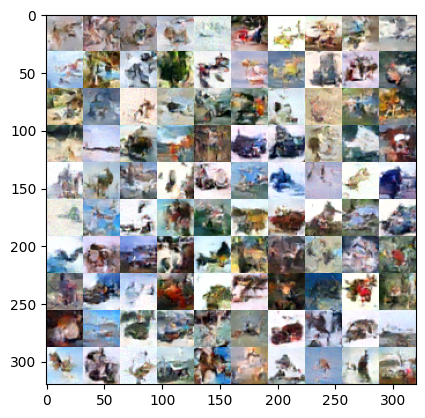

In [6]:
with torch.no_grad():
    traj = node.trajectory(
        torch.randn(100, 3, 32, 32).to(device),
        t_span=torch.linspace(0, 1, 100).to(device),
    )
grid = make_grid(
    traj[-1, :100].view([-1, 3, 32, 32]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
imshow(grid.detach().cpu())

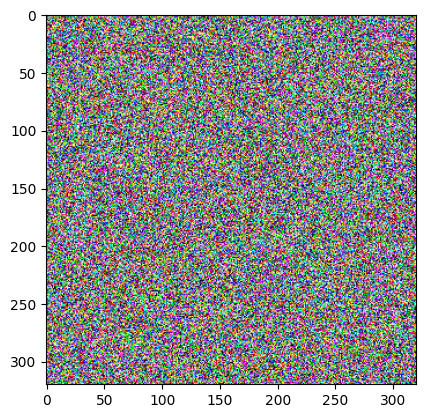

In [7]:
new_net = UNetModelWrapper(
    dim=(3, 32, 32),
    num_res_blocks=2,
    num_channels=64,
    channel_mult=[1, 2, 2, 2],
    num_heads=4,
    num_head_channels=64,
    attention_resolutions="16",
    dropout=0).to(device)

node = NeuralODE(new_net, solver="euler", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

with torch.no_grad():
    traj = node.trajectory(
        torch.randn(100, 3, 32, 32).to(device),
        t_span=torch.linspace(0, 1, 100).to(device),
    )
grid = make_grid(
    traj[-1, :100].view([-1, 3, 32, 32]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
imshow(grid.detach().cpu())


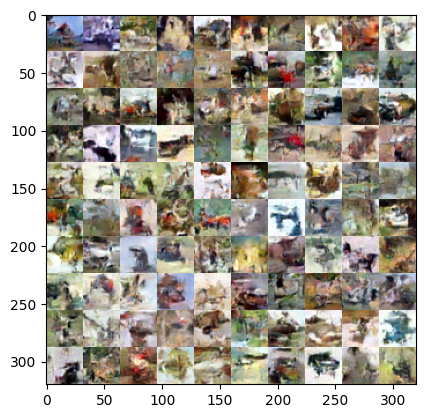

In [9]:
PATH = 'weights/reproduced_cifar10_weights_epoch_{}.pt'.format(n_epochs-2)
checkpoint = torch.load(PATH)
new_net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

new_net.eval()

with torch.no_grad():
    traj = node.trajectory(
        torch.randn(100, 3, 32, 32).to(device),
        t_span=torch.linspace(0, 1, 100).to(device),
    )
grid = make_grid(
    traj[-1, :100].view([-1, 3, 32, 32]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
imshow(grid.detach().cpu())